## Observation of the melting ice: facade of the Eqi glacier

Here is a link to better visualize the notebook : [nbviewer link](https://nbviewer.org/github/barthh/geo-data-eqi-glacier/blob/main/Facade-sentinel.ipynb)

We used Sentinel dataset for the study

In [1]:
# Planetary Computer, STAC
import pystac
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Stats and vector data
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

# Image processing
import rasterio as rio
import rasterio.plot, rasterio.features, rasterio.mask, rasterio.fill  # Not loaded by default
import skimage.morphology, skimage.measure

# Plotting
import matplotlib.pyplot as plt
import IPython.display
import ipywidgets
import leafmap

# For nice HTML outputs
import rich.table

## Environment

In [2]:
plt.style.use('default')
folium_tile = "CartoDB Positron"

## Import images from Sentinel

We searched images on Planetary Computer Explorer because it was easier

### Import 2018 image

In [3]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20190811T153911_R011_T22WEC_20201004T230332"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
before = planetary_computer.sign(item)

In [4]:
before.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20190811T153911_R011_T22WEC_20201004T230332&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0'

In [5]:
before;

In [6]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=before.assets["rendered_preview"].href, width=500)

### Import 2022 image

In [7]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220830T153809_R011_T22WEC_20220831T203742"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
after = planetary_computer.sign(item)

In [8]:
after.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2B_MSIL2A_20220830T153809_R011_T22WEC_20220831T203742&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0'

In [9]:
after;

In [10]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=after.assets["rendered_preview"].href, width=500)

## Explore a dataset

In [11]:
# Rich provides an easy way to build pretty HTML tables
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in before.assets.items():
    table.add_row(asset_key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

In [12]:
# Load full georeferenced false color (NIR) image with Leafmap
m = leafmap.Map()
m.add_stac_layer(
    collection="sentinel-2-l2a",
    name=before.datetime.strftime('%Y.%m.%d'),
    item=before.id,
    assets=["B08"]
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Rasterio

In [13]:
# Open a remote 8bit GeoTIFF dataset to fetch image geometry
with rio.open(before.assets["visual"].href) as ds:
    profile = ds.profile

In [14]:
# We can use the same profile dict for different bands since this 3 things are constant
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint8',
    'nodata': None,
    'width': 10980,
    'height': 10980,
    'count': 3,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 7800000.0),
    'blockxsize': 512,
    'blockysize': 512,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'pixel'
}

In [15]:
# Keep a reference to the CRS
crs = profile['crs']

In [16]:
profile['height'], profile['width']

(10980, 10980)

Pictures are 10980 x 10980

The middle of Eqi is located at 528_980 and 7_743_000

In [17]:
# Map size
size = 1000

In [18]:
# facade of the glacier coords
horizontal_coord = 528_980
vertical_coord = 7_743_000

In [19]:
# Horizontal coord is 528_980
left_coord = horizontal_coord - (size/2) * 10
right_coord = horizontal_coord + (size/2) * 10

In [20]:
# Vertical coord is 7_743_000
top_coord = vertical_coord + (size/2) * 10
bottom_coord = vertical_coord - (size/2) * 10

We multiplied by 10 because each pixel is 10m

In [21]:
# Build a window
warped_aoi_bounds = (
    left_coord,
    bottom_coord,
    right_coord,
    top_coord
)

# Round pixel size and offsets: we can't slice any array using floating points
aoi_window = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile["transform"])
aoi_window = aoi_window.round_shape().round_offsets()
aoi_window

Window(col_off=2400, row_off=5200, width=1000, height=1000)

In [22]:
# Extract 8bit image within ROI, get data as numpy arrays
with rio.open(before.assets["visual"].href) as ds:
    viz_before = ds.read(window=aoi_window)

In [23]:
with rio.open(after.assets["visual"].href) as ds:
    viz_after = ds.read(window=aoi_window)

In [24]:
# Bands, Latitude, Longitude
print("bands: {},\nrows: {},\ncols: {}\n".format(*viz_before.shape) + f"dtype: {viz_before.dtype}")

bands: 3,
rows: 1000,
cols: 1000
dtype: uint8


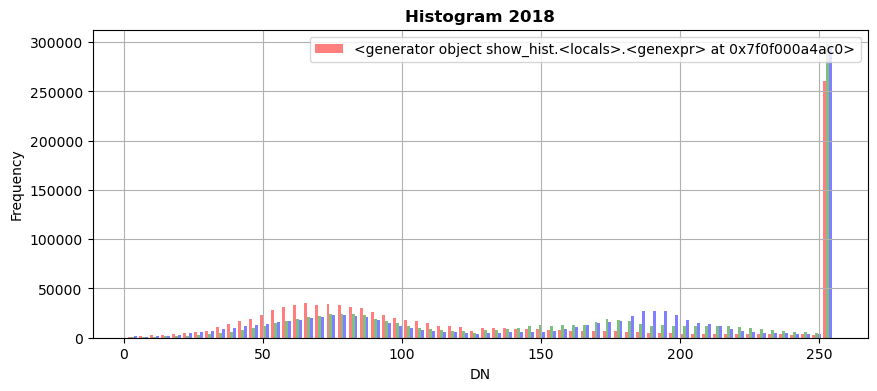

In [25]:
# Visualize histogram of pixel values.
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(viz_before, bins=64, stacked=False, alpha=0.5, title="Histogram 2018")

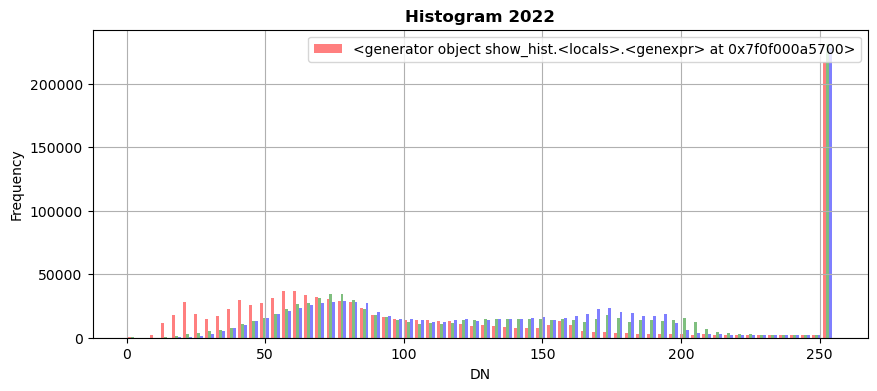

In [26]:
# Visualize histogram of pixel values.
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(viz_after, bins=64, stacked=False, alpha=0.5, title="Histogram 2022")

As we see, there is a huge quantity of values at 255

It sounds logical, to make white color, we need rgb colors at 255

## Numpy array manipulations and plotting

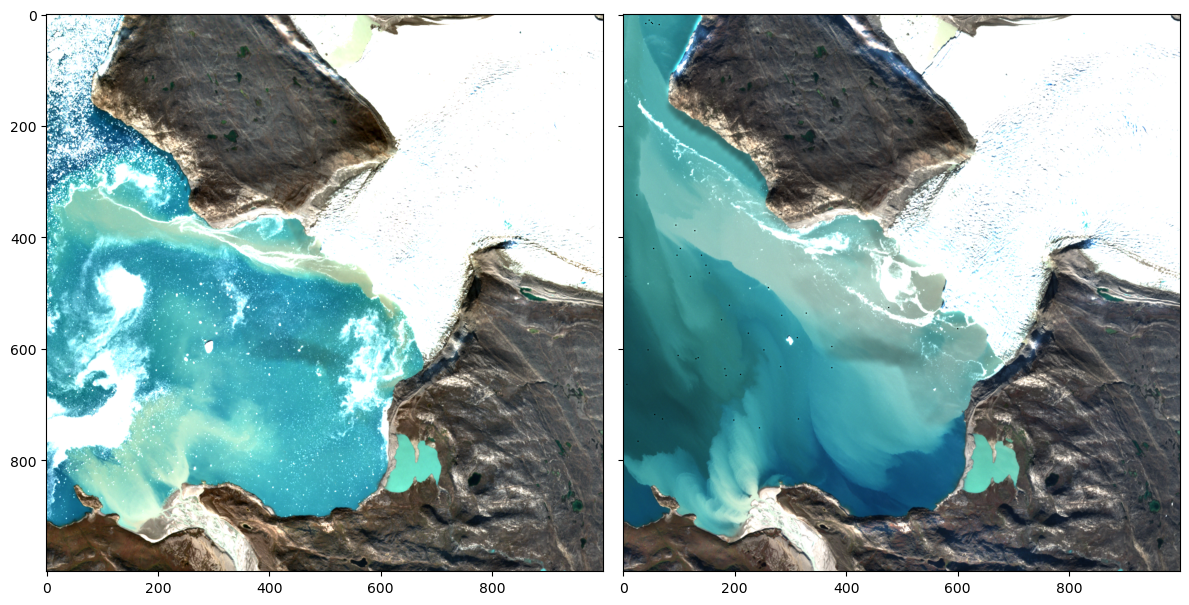

In [27]:
# Plot two images side by side, matplotlib axis with pixel coords
fig, axes = plt.subplots(1,2, figsize=(12,16), sharey=True, layout="tight")
axes[0].imshow(rio.plot.reshape_as_image(viz_before))
axes[1].imshow(rio.plot.reshape_as_image(viz_after))

As we can see, the windows have been applied and we can see the glacier better

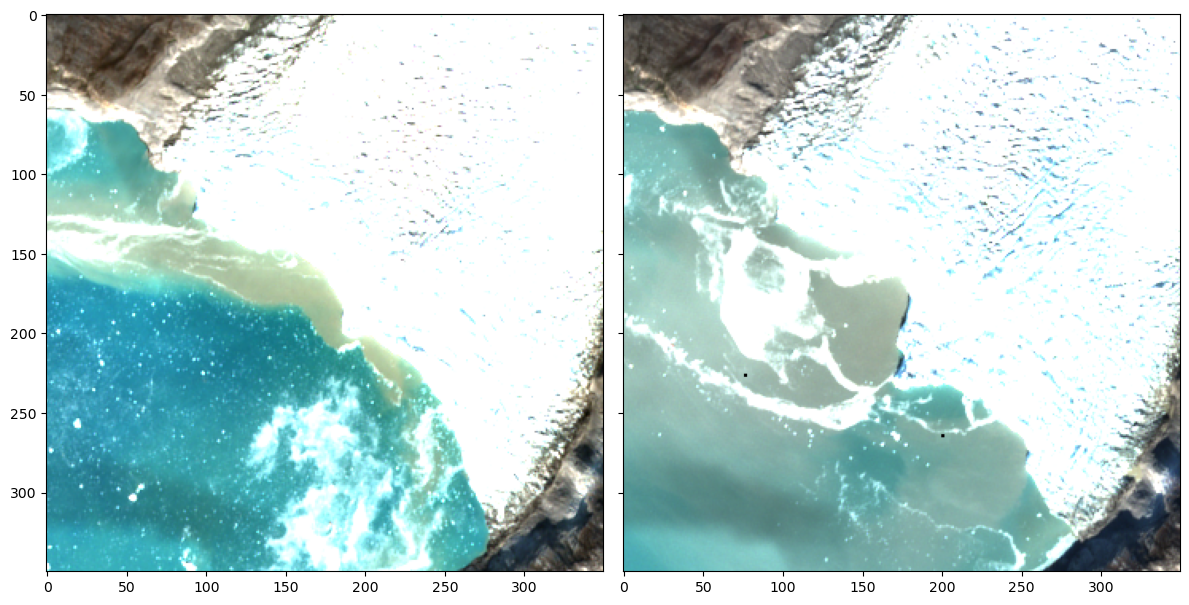

In [28]:
# Zoom on the glacier zone
fig, axes = plt.subplots(1,2, figsize=(12,16), sharey=True, layout="tight")
axes[0].imshow(np.moveaxis(viz_before, 0, 2)[300:650, 400:750, :])
axes[1].imshow(np.moveaxis(viz_after, 0, 2)[300:650, 400:750, :])

### Analyze R,G,B bands

In [29]:
# Load 16bit data as numpy array, using rasterio to open remote COG file
def rio_stack(
    item: pystac.Item,
    band_list: list,
    window: rio.windows.Window = None
):
    """Load and stack different bands in a STAC item, return stacked array and geometry profile"""
    array_list = []
    # Collect arrays
    for band_id in band_list:
        url = item.assets[band_id].href
        with rasterio.open(url) as ds:
            profile = ds.profile
            data = ds.read(1, window=window)  # read(1) returns 2D array
            array_list.append(data)
    # Update metadata dict
    profile["count"] = len(array_list)
    if window is not None:
        # Update image geometry
        profile["transform"] = rio.windows.transform(aoi_window, profile["transform"])
        # ! Width and height are integer since we used aoi_window.round_shape() !
        profile["width"], profile["height"] = aoi_window.width, aoi_window.height

    # N.B. this function is valid if only if all bands have the same geometry
    return np.stack(array_list), profile

Since each here bands have the same resolution, we can stack them

In [30]:
# Here we also reorder BGR bands to RGB
array_before, profile = rio_stack(before, ["B04", "B03", "B02", "B08"], aoi_window)
array_after, profile = rio_stack(after, ["B04", "B03", "B02", "B08"], aoi_window)

# Display profile
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 1000,
    'height': 1000,
    'count': 4,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(10.0, 0.0, 523980.0,
       0.0, -10.0, 7748000.0),
    'blockxsize': 512,
    'blockysize': 512,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [31]:
array_before.max(), array_after.max()

(17344, 17216)

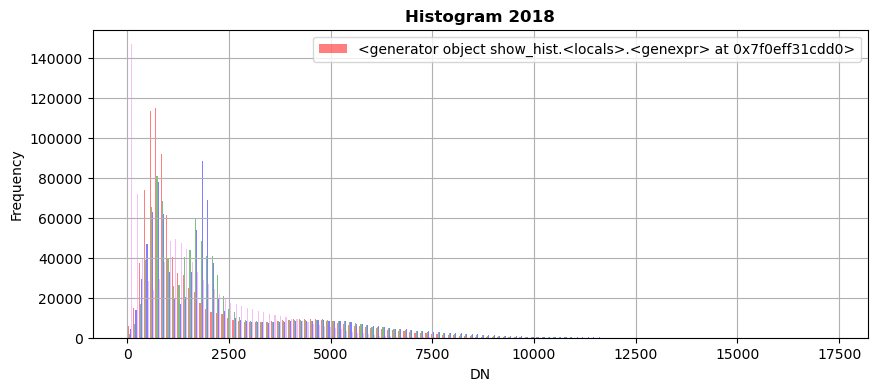

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_before, bins=128, stacked=False, alpha=0.5, title="Histogram 2018");

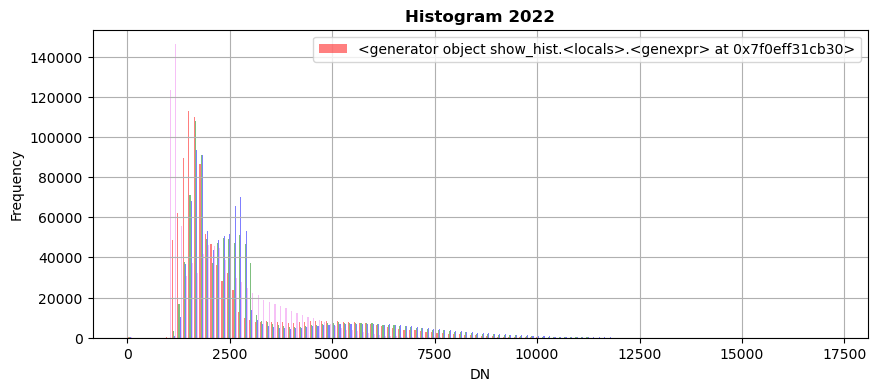

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_after, bins=128, stacked=False, alpha=0.5, title="Histogram 2022")

In [34]:
array_reshaped = array_before.reshape([4, -1])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

Min:  [1 1 1 1]
Max:  [14616 16376 17344 11152]
Mean [1943.322436 2367.926785 2395.39088  1613.699235]
Std [1876.40331759 1986.83779994 2081.78591395 1434.18053121]


In [35]:
# There is no 0, it means there is no pixel without data

In [36]:
array_reshaped = array_after.reshape([4, -1])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

Min:  [0 0 0 0]
Max:  [16608 16864 17216 12256]
Mean [2624.812972 3038.70474  3101.943345 2258.828897]
Std [1710.23380856 1878.9509223  1964.69252651 1211.92078706]


In [37]:
# In this array, zero is used as nodata value.

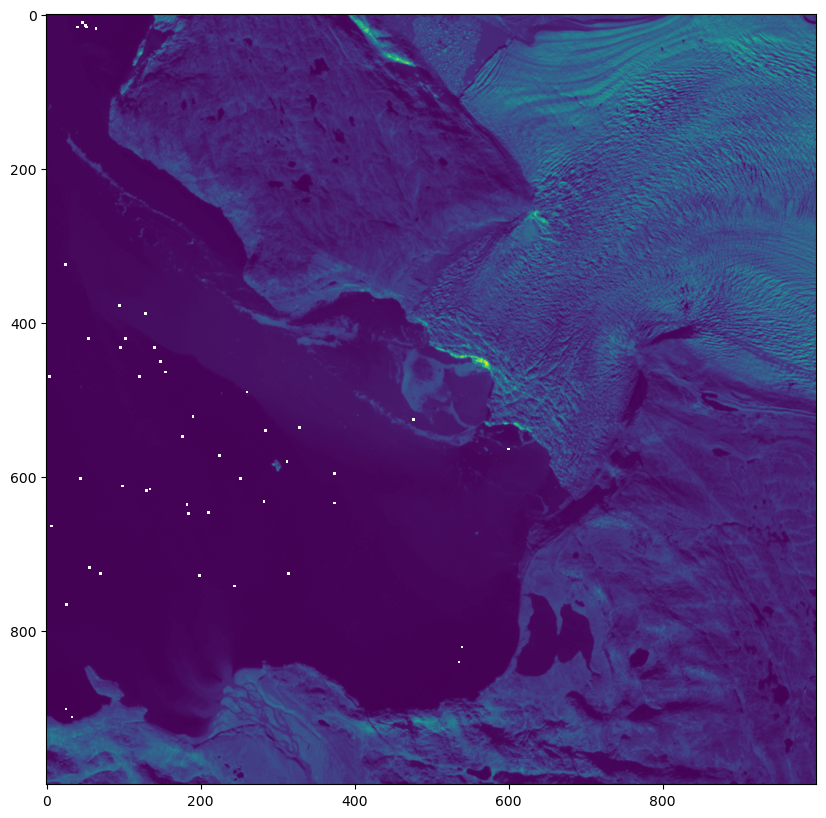

In [38]:
# Let's display NaN values
with rasterio.open(after.assets['B08'].href) as ds:
    profile = ds.profile
    mask = ds.read_masks(window=aoi_window)
    data = ds.read(window=aoi_window)

# Let's build a numpy masked array. We need to invert it since GDAL and Numpy aren't using the same convention
mask = ~mask.astype(bool)

# Build a mask, we decide to fill missing values with the dataset declared nodata value (e.g. zero)
masked_data = np.ma.masked_array(data, mask, fill_value=profile['nodata'])

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(masked_data[0]);

Since there are no lots of NaN values, we won't worry about it

In [39]:
# Use slicing to get first bands (Keep RGB)
array_3b_before, array_3b_after = array_before[:3], array_after[:3]
array_3b_before.shape, array_3b_after.shape

((3, 1000, 1000), (3, 1000, 1000))

In [40]:
new_array_before = np.moveaxis(array_3b_before, 0, 2)
new_array_before = np.interp(new_array_before, (300, 3000), (0, 255))

In [41]:
new_array_after = np.moveaxis(array_3b_after, 0, 2)
new_array_after = np.interp(new_array_after, (1000, 3000), (0, 255))

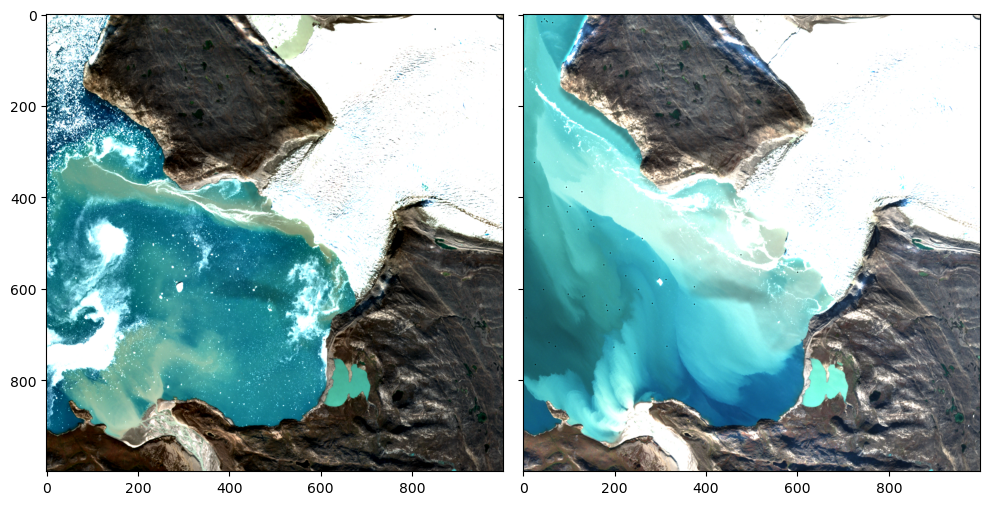

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(new_array_before.astype('uint8'))
axes[1].imshow(new_array_after.astype('uint8'));

We notice that by trying to reconstruct the image with the three rgb bands provided in the dataset, we get an image too dark for the dataset of 2018.

By modifying parameters, we can have "normal" colors

Let's observe RGB color repartition

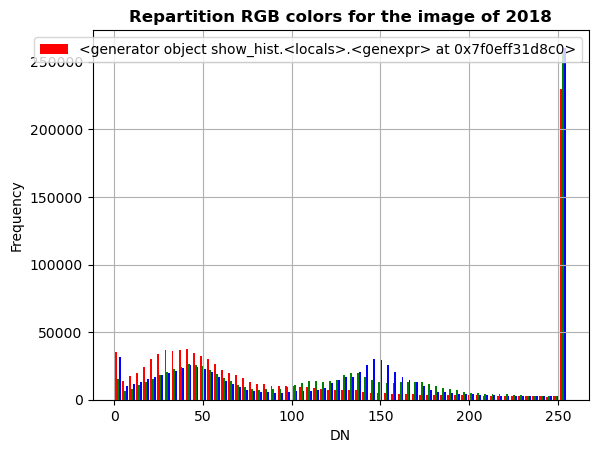

In [43]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_before), bins=64,title="Repartition RGB colors for the image of 2018")

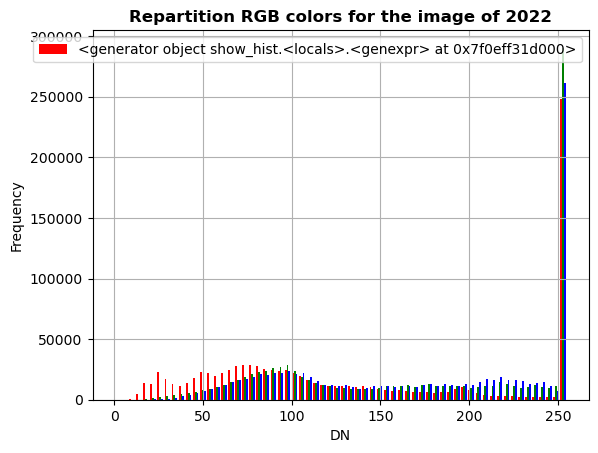

In [44]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_after), bins=64,title="Repartition RGB colors for the image of 2022")

In [45]:
del new_array_before, new_array_after

## Computations

## Image resampling

We need to compute bands with different resolution. 

Indeed, the SWIR band has a resolution of 20m while the others used (R,G,B, NIR) have a resolution of 10m. It is then necessary to increase the resolution of the SWIR band and splitting each pixel both horizontally and vertically 

In [46]:
# Resamplign algorithms : 
def rio_open_resampled(url, scale_factor=2):
    """Open a dataset using rasterio and scale pixel size according to given factor"""
    with rio.open(url) as ds:
        profile = ds.profile
        # compute new shape
        new_height, new_width = int(ds.height * scale_factor), int(ds.width * scale_factor)
        # read data and resample on the fly
        data = ds.read(
            out_shape=(ds.count, new_height, new_width),
            resampling=rio.enums.Resampling.cubic
        )  # https://en.wikipedia.org/wiki/Bicubic_interpolation
        # scale image transform
        transform = ds.transform * ds.transform.scale(
            (ds.width / data.shape[-1]),
            (ds.height / data.shape[-2])
        )
        # update metadata
        profile.update({"transform": transform, "height": new_height, "width": new_width})

        return data, profile

In [47]:
def windowed_array(array, window):
    col_start, row_start = window.col_off, window.row_off
    col_end, row_end = window.col_off + window.width, window.row_off + window.height
    return array[:, row_start:row_end, col_start:col_end]

In [48]:
# A function that (given a Sentinel-2 STAC item) returns a 5 bands array (R,G,B,NIR,SWIR) and profile dict
# Add an optional "window" argument. Use existing functions rio_stack, rio_open_resampled and windowed_array
def get_s2_bands(item: pystac.Item, window: rasterio.windows.Window = None):
    array, profile = rio_stack(item, ["B04", "B03", "B02", "B08"], window)
    b12, _ = rio_open_resampled(item.assets["B12"].href)
    if window is not None:
        b12 = windowed_array(b12, window)
    array = np.concatenate([array, b12])
    profile['count'] += 1
    return array, profile

In [49]:
get_s2_bands(before, aoi_window)[0].shape

(5, 1000, 1000)

We have 5 bands : Red, Green, Blue, Nir, Swir

## Index & Compute

There are different indexes. The one that is interesting is the NDSI which is the Normalized Difference Snow Index.

### NDSI compute

In [50]:
def compute_ndsi(array: np.ndarray):
    array = array.astype(np.float32)
    green, swir = array[1], array[4]
    return (green - swir) / (green + swir)

In [62]:
array_before, profile = get_s2_bands(before, window=aoi_window)
#array_before[:3] = np.interp(array_before[:3], (300, 4000), (0, 255))
ndsi_before = compute_ndsi(array_before)

In [63]:
array_after, profile = get_s2_bands(after, window=aoi_window)
ndsi_after = compute_ndsi(array_after)

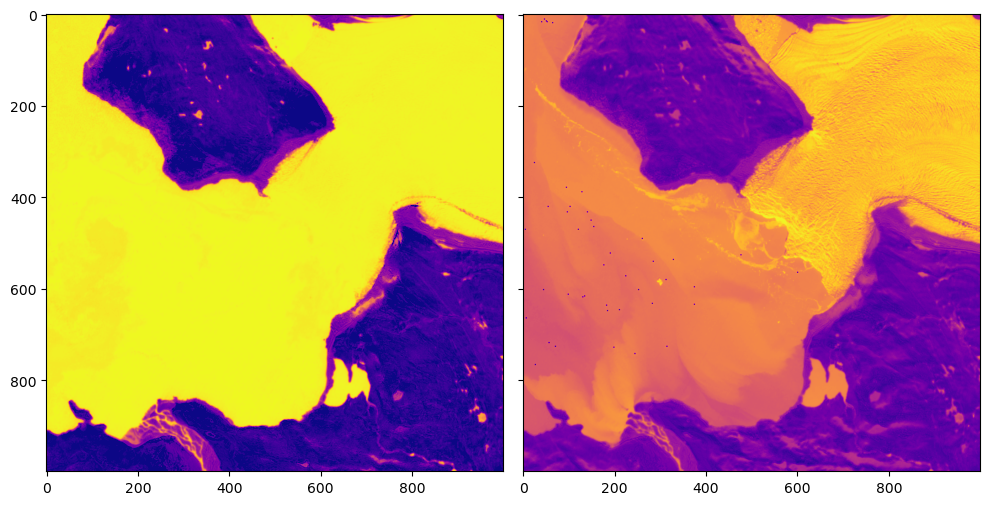

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(ndsi_before, vmin=-0.5, cmap="plasma", interpolation="bilinear")
axes[1].imshow(ndsi_after, vmin=-0.5, cmap="plasma", interpolation="bilinear");

In [66]:
dndsi = ndsi_before - ndsi_after

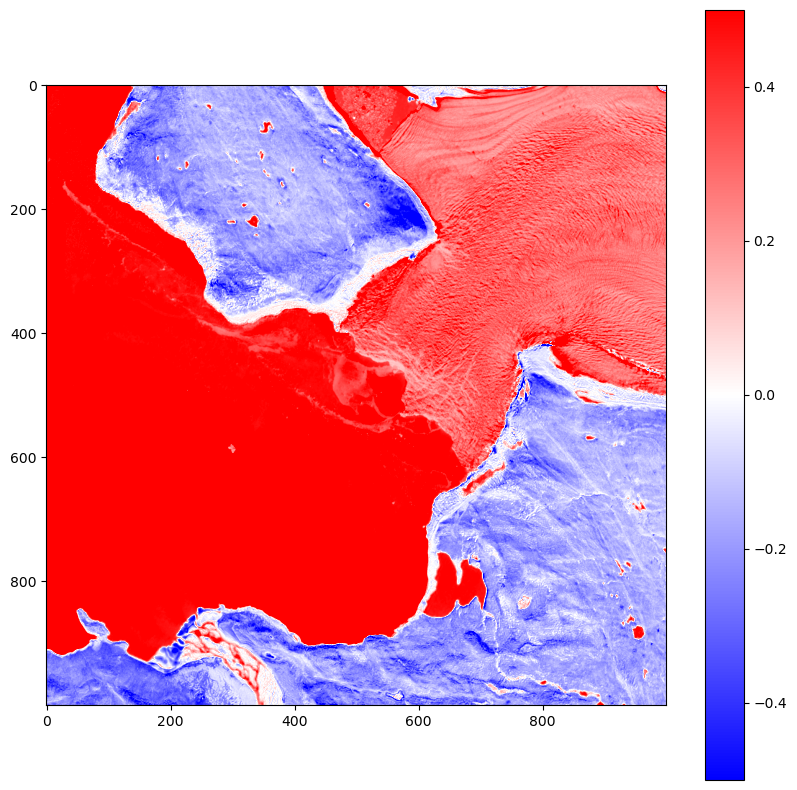

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi, vmin=-0.5, vmax=0.5, cmap='bwr')
fig.colorbar(ax.get_children()[0]);  #Sometimes it is necessary to pass the mappable object to Colorbar()

The problem is that the water is also in red. 

We have to compute NDWI (For water) and substract it to the previous NDSI

### NDWI compute

In [68]:
def compute_ndwi(array: np.ndarray):
    array = array.astype(np.float32)
    green, nir = array[1], array[3]
    return (green - nir) / (green + nir)

In [69]:
array_before, profile = get_s2_bands(before, window=aoi_window)
ndwi_before = compute_ndwi(array_before)

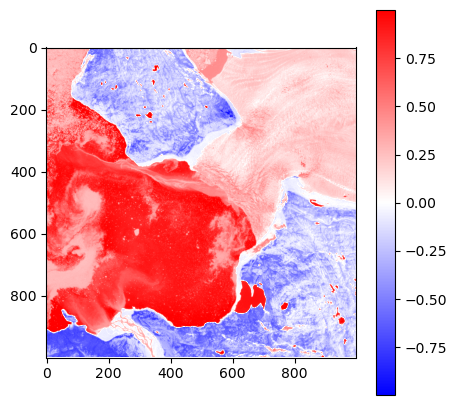

In [70]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ndwi_before, cmap='bwr')
fig.colorbar(ax.get_children()[0]) 

In [71]:
mask_before = 0.5

In [72]:
# We will use the NDWI as a mask.
ndwi_before[ndwi_before > mask_before] = 1
ndwi_before[ndwi_before <= mask_before] = 0

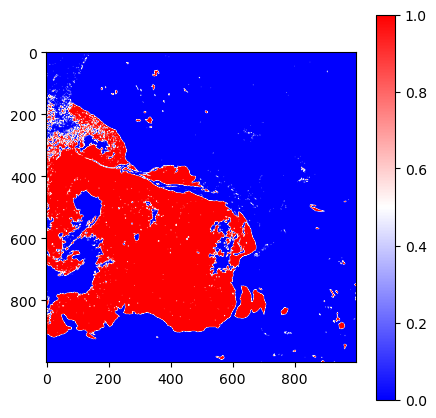

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ndwi_before, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

In [74]:
glacier_before = ndsi_before - ndwi_before
glacier_before[glacier_before < -1] = -1

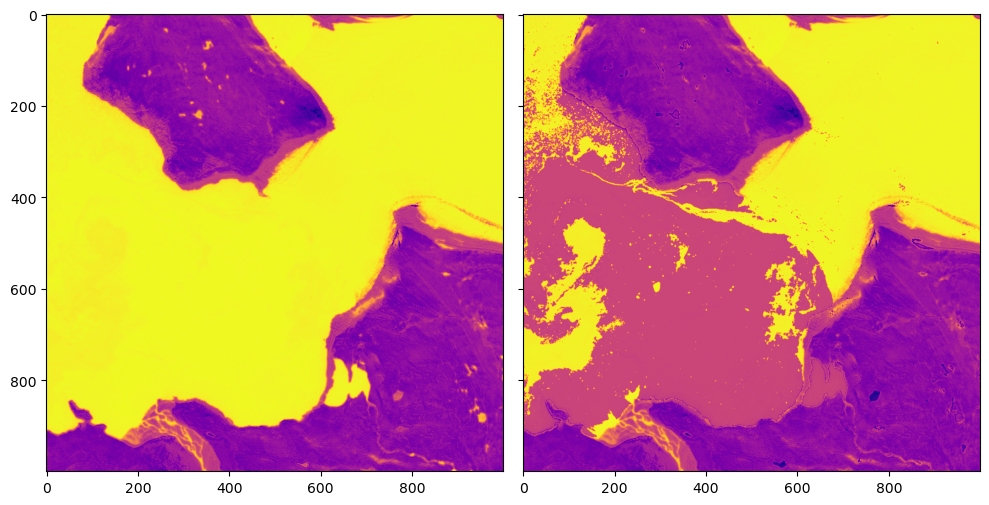

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(ndsi_before,cmap="plasma", interpolation="bilinear")
axes[1].imshow(glacier_before, cmap="plasma", interpolation="bilinear");

We observe that we delete the water part

### Difference between before & after

In [76]:
glacier = glacier_before - ndsi_after

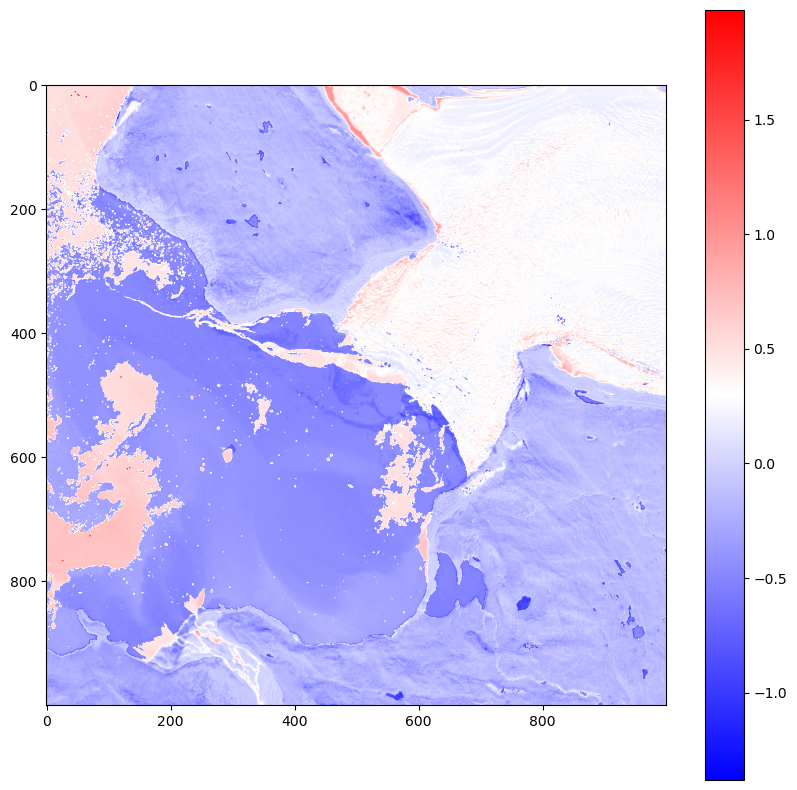

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(glacier, cmap='bwr')
fig.colorbar(ax.get_children()[0]); 

NDSI results differ too much between before & after.

We think that the problem comes from the fact that the green color has too many dark values (close to 0) and when we try to render with the three RGB bands, the image is too dark.

A solution would be to filter according to the intensity of the red, blue and green colors. The glacier being white, we could just keep the light parts.

We could also take RGB colors of the "visual" bands. As we saw, they are better. (Less dark colors)

We chose another source to try again, on the landsat dataset.

If you have an idea about the problem, do not hesitate to make an issue 